# Time Series

In [27]:
import sys
import sklearn
import tensorflow
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data generator and baseline for comparison.
# Combination of 2 sine waves plus noise
def generate_time_series (batch_size, n_steps):
    freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offset1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offset2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[..., np.newaxis].astype(np.float32)

In [28]:
# Training set, etc.
n_steps = 50
series = generate_time_series (10000, n_steps+1)
X_train,y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid,y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test,y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape

(7000, 50, 1)

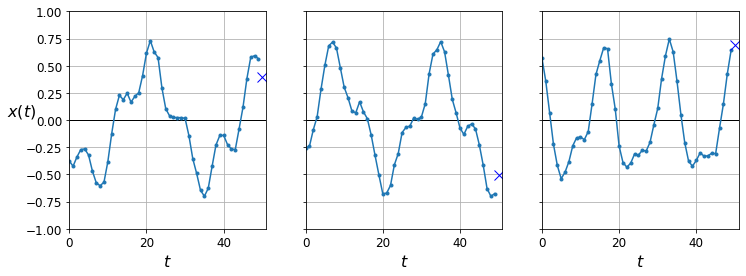

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()
# Here are three validation instances

## Try a naive predictor
prediction = previous value

In [35]:
naive_pred = X_valid[:,-1] # prediction = previous value
naive_mse = np.mean(keras.losses.mean_squared_error(y_valid,naive_pred))
naive_mse
# MSE

0.020211367

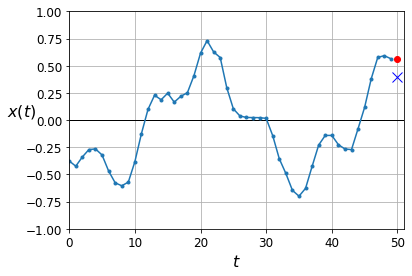

In [36]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], naive_pred[0, 0])
plt.show()
# The red dot is the naive prediction for validation instance 0.

## Try a traditional neural network.
Use the keras Sequential API.
By default, this uses linear regression.
Flatten each instance into 50 features (lose sense of time).
Use a fully dense neural network.
Use MSE loss.
Use Adam optimizer (default).
The mini-batch size (219) is due to my memory constraint;
it was 7000 in the book using Google CoLab.

In [47]:
dnn = keras.models.Sequential(
    [keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)])  # more layers didn't help
dnn.compile(loss="mse", optimizer="adam")
history = dnn.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
# Num parameters = W + bias = 50+1 = 51.
# MSE loss stabilizes at 0.004

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.3620 - val_loss: 0.1053
Epoch 2/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0706 - val_loss: 0.0467
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0265
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0225 - val_loss: 0.0180
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0158 - val_loss: 0.0136
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 7/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 8/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0075

In [48]:
# Different route to same estimate
dnn.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0046


0.004630967043340206

## Simple RNN
Single layer, single neuron. 
No need to specify 50 timepoints. 
By default, initial h_init value is zero.
By default, SimpleRNN activation is tanh().
The mini-batch size (219) is due to my memory constraint;
it was 7000 in the book using Google CoLab.
Number of parameters to train is 3: w_in + w_out + bias.
This simple RNN does not beat the simple DNN.

In [49]:
units = 1
optimizer = keras.optimizers.Adam(lr=0.005)
rnn1 = keras.models.Sequential([
    keras.layers.SimpleRNN(units,input_shape=[None,1]) 
])  # num timepoints = None
rnn1.compile(loss="mse", optimizer=optimizer)
history = rnn1.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1018 - val_loss: 0.0443
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0345 - val_loss: 0.0281
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0243 - val_loss: 0.0210
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0192 - val_loss: 0.0172
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0162 - val_loss: 0.0148
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0130 - val_loss: 0.0122
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0123 - val_loss: 0.0115
Epoch 9/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0115 - val_los

## wider RNN
Add more units i.e. more neurons in the single layer.
This helps a little bit.

In [50]:
units = 5
rnn2 = keras.models.Sequential([
    keras.layers.SimpleRNN(units,input_shape=[None,1]) 
])  # num timepoints = None
rnn2.compile(loss="mse", optimizer=optimizer)
history = rnn2.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0980 - val_loss: 0.0676
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0555 - val_loss: 0.0505
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0419 - val_loss: 0.0388
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0329 - val_loss: 0.0299
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0277 - val_loss: 0.0248
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0226 - val_loss: 0.0204
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0197
Epoch 8/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0174 - val_loss: 0.0159
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0154 - val_loss: 0.0143
Epoch 10/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0139 - val_lo

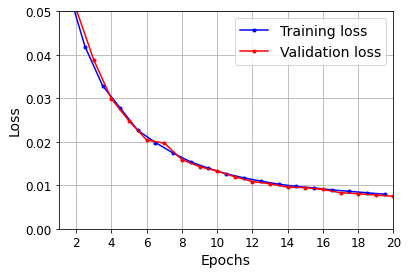

In [52]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## deeper RNN
Add more layers.

In [54]:
rnn3 = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20,return_sequences=True),
    keras.layers.SimpleRNN(1)    
])
# The single-unit last layer is there to output a single number.
rnn3.compile(loss="mse", optimizer=optimizer)
history = rnn3.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))  

Epoch 1/20
219/219 [==============================] - 8s 38ms/step - loss: 0.2135 - val_loss: 0.0209
Epoch 2/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0135 - val_loss: 0.0079
Epoch 3/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 4/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0079 - val_loss: 0.0064
Epoch 5/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0091 - val_loss: 0.0064
Epoch 6/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 7/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0072 - val_loss: 0.0059
Epoch 8/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 9/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 10/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0065 - val_lo

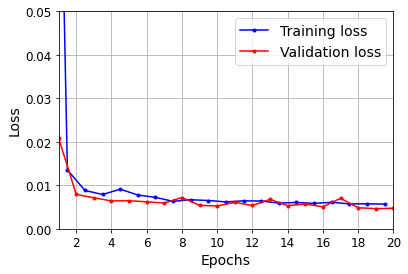

In [55]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## deep RNN with dense layer
We can do better using Dense for the last layer.
Continue to use a single unit so we get a single number output.
But keras Dense() does better than keras SimpleRNN in last layer.
It trains faster and gets better accuracy.
It can have a different activation function from the other layers.

In [59]:
# deep RNN with dense layer
rnn4 = keras.models.Sequential([
    keras.layers.SimpleRNN(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(20), # no sequences into the dense layer
    keras.layers.Dense(1)    
])
rnn4.compile(loss="mse", optimizer=optimizer)
history = rnn4.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))  

Epoch 1/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0162 - val_loss: 0.0046
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 7/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0036 - val_lo

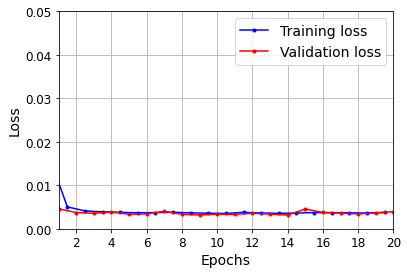

In [60]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
# Now it trains much faster.